In [1]:
import os
os.environ['OPENBLAS_NUM_THREADS'] = '1'       #Disactivate multiprocessing for numpy
import numpy as np
import matplotlib.pyplot as plt
import json
import gymnasium as gym
import yaml
from datetime import datetime

import stable_baselines3
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.vec_env import VecNormalize, SubprocVecEnv
from stable_baselines3 import PPO, A2C, SAC, TD3
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.noise import NormalActionNoise, OrnsteinUhlenbeckActionNoise
from stable_baselines3.common.callbacks import EvalCallback, CallbackList, CheckpointCallback

from sogym.env import sogym
from sogym.mmc_optim import run_mmc
from sogym.env import sogym
from sogym.expert_generation import generate_expert_dataset, generate_mmc_solutions, generate_dataset
from sogym.utils import profile_and_analyze,ImageDictExtractor, CustomBoxDense
from sogym.callbacks import FigureRecorderCallback, MaxRewardCallback, GradientNormCallback
from sogym.pretraining import pretrain_agent, ExpertDataSet

import torch
import torch as th
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import random_split, Dataset

%load_ext autoreload
%autoreload 2

print('SB3 version:', stable_baselines3.__version__)
# Let's make the code device agnostic:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using device:', device)

SB3 version: 2.2.1
Using device: cuda


---
### Environment test and visualization:

In [2]:
# Let's test the environment using the check_env util from SB3:
observation_type = 'image'
train_env = sogym(mode='train',observation_type=observation_type,vol_constraint_type='hard',resolution=50,check_connectivity = True)
eval_env = sogym(mode='test',observation_type=observation_type,vol_constraint_type='hard',resolution=50,check_connectivity=True)

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

[-0.46374828  0.81207687 -0.8963759   0.7595936   0.9416236   0.7277135 ]
[-0.30606973 -0.0491755  -0.760215    0.8483492  -0.9363419  -0.36094844]
[ 0.7344511  -0.24158916 -0.8847978   0.06316704  0.28622296 -0.8546042 ]
[ 0.93793046  0.41832328 -0.82537097  0.21243857  0.82969147  0.24925756]
[-0.98316324 -0.10443714 -0.8899654   0.09276891  0.11732262 -0.3910789 ]
[ 0.74293405 -0.6692614  -0.3266315  -0.7247944  -0.81826353  0.5445791 ]
[-0.43612888  0.48251918  0.7253474   0.92227745  0.45133823 -0.08856352]
[-0.0593651   0.6110155  -0.8679693  -0.19620202 -0.44162685  0.10002508]
0.0


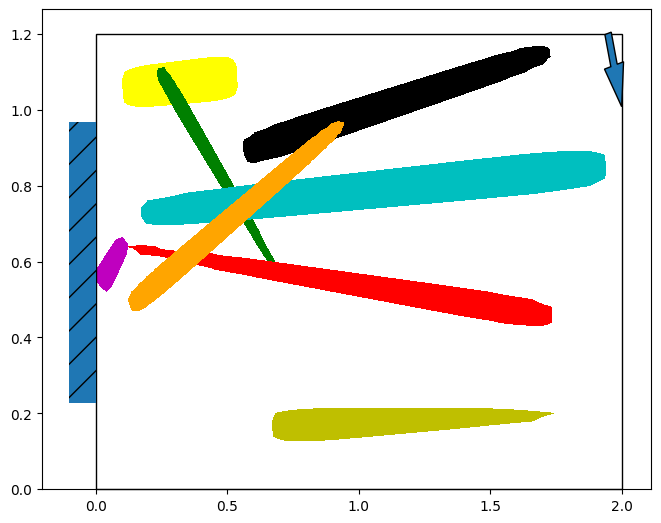

In [11]:
obs,info=train_env.reset()
dones = False
#use deepcopy to save 
while dones== False:
    action = train_env.action_space.sample()
    print(action)
    obs, rewards, dones,truncated, info = train_env.step(action)
print(rewards)
train_env.plot()

In [12]:
# It will check your custom environment and output additional warnings if needed
check_env(sogym(mode='train',observation_type='image'))

KeyboardInterrupt: 

In [ ]:
# Example usage
# Specify the number of episodes to run
num_episodes = 20
# Call the profile_and_analyze function
result_df = profile_and_analyze(num_episodes, train_env)
# Print the resulting DataFrame
result_df

,Full Function Path,ncalls,tottime,percall (tottime),cumtime,percall (cumtime)
126,/scratch/thomas/GitHub/sogym_v2/sogym/utils.py...,1,0.001416,1.416293e-03,24.857043,2.485704e+01
218,/scratch/thomas/GitHub/sogym_v2/sogym/env.py:1...,160,0.026677,1.667297e-04,23.908802,1.494300e-01
219,/scratch/thomas/GitHub/sogym_v2/sogym/env.py:2...,160,0.014879,9.299674e-05,14.138248,8.836405e-02
231,/scratch/thomas/GitHub/sogym_v2/sogym/struct.p...,160,0.136937,8.558544e-04,14.123368,8.827105e-02
128,/home/thomas/anaconda3/envs/SB3_update/lib/pyt...,160,0.002620,1.637755e-05,12.141764,7.588602e-02
...,...,...,...,...,...,...
11,~:0(<built-in method builtins.id>),331152,0.028034,8.465653e-08,0.028034,8.465653e-08
1256,~:0(<built-in method math.factorial>),17820,0.001464,8.215561e-08,0.001464,8.215561e-08
81,~:0(<method 'items' of 'dict' objects>),920223,0.075594,8.214738e-08,0.075594,8.214738e-08
3,~:0(<built-in method builtins.callable>),117688,0.009467,8.044547e-08,0.009467,8.044547e-08


In [ ]:
obs = train_env.reset()
cfg = {
            'optimizer':'mma', #optimiser choice
            'xInt':0.25, #initial interval of components in x
            'yInt':0.25, #initial interval of components in y
            'E':1.0, #Young's modulus
            'nu':0.3, #Poisson ratio
            'h':1, #thickness
            'dgt0':5, #significant digit of sens.
            'scl':1, #scale factor for obj
            'p':6,  #power of super ellipsoid
            'lmd':100, #power of KS aggregation   
            'maxiter':500, # maximum number of outer iterations
            'alpha':1e-9, # This is the threshold level in the Heaviside function
            'epsilon':0.2, #This is the regularization term in the Heaviside function
            'maxinnerinit':1, # This is the maximum number of inner iterations for GCMMA
            'switch':-0.000002, # This is the switch criteria for the hybrid optimizer
            'convergence_threshold':2e-4, #This is the threshold for the relative change in the objective function
            'xmin':(0.0, 0.0, 0.0, 0.00, 0.00, -np.pi),
            'xmax':(train_env.dx, train_env.dy, 0.7*min(train_env.dx,train_env.dy), 0.05*min(train_env.dx,train_env.dy),0.05*min(train_env.dx,train_env.dy), np.pi)
        }

#run_mmc(train_env.conditions,train_env.nelx,train_env.nely,train_env.dx,train_env.dy,plotting='contour',verbose=0,cfg=cfg)
dataset_folder = "/home/thomas/Documents/scratch_thomas/GitHub/sogym_v2/dataset/topologies/mmc"
#generate_mmc_solutions(key=0,dataset_folder="/home/thomas/Documents/scratch_thomas/GitHub/sogym_v2/dataset/topologies/mmc")
generate_dataset(dataset_folder= dataset_folder, num_threads=32, num_samples=20000)

In [ ]:
# Let's visualize the training environment on a random problem statement and visualize a 'successful' solution:
reward = 0.0
while reward==0.0:
    obs = train_env.reset()
    done = False
    while not done:
        action = train_env.action_space.sample()
        obs, reward, done,truncated, info = train_env.step(action)
        
# print("Volume: ", train_env.volume)
print("Reward ",reward)

train_env.plot()

In [ ]:
import matplotlib.pyplot as plt

# Create a figure and axes for the subplots
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(10, 10))
axes = axes.flatten()

# Initialize the index for the current subplot
subplot_index = 0

# Let's visualize the training environment on a random problem statement and visualize a 'successful' solution:
reward = 0.0
while reward == 0.0:
    obs = train_env.reset()
    done = False
    while not done:
        action = train_env.action_space.sample()
        obs, reward, done, truncated, info = train_env.step(action)
        
        # Plot the current observation image
        axes[subplot_index].imshow(obs['strain_energy'].T, cmap='gray')
        axes[subplot_index].axis('off')
        axes[subplot_index].set_title(f"Timestep {subplot_index+1}")
        
        # Increment the subplot index
        subplot_index += 1
        
        # If all subplots are filled, display the plot and reset the index
        if subplot_index == len(axes):
            plt.tight_layout()
            plt.show()
            subplot_index = 0

# Print the reward
print("Reward:", reward)

# Plot the final state of the training environment
train_env.plot()

# Display any remaining subplots
if subplot_index > 0:
    for i in range(subplot_index, len(axes)):
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()


In [3]:
# Specify the number of permutations to generate
num_permutations = 1
observation_type = "image"

# Specify the environment configuration (optional)
env_kwargs = {
    'mode': 'train',
    'observation_type': 'image',
    'vol_constraint_type': 'hard',
    'seed': 42,
    'resolution' : 50,
    'check_connectivity':True
}

directory_path = "/home/thomas/Documents/scratch_thomas/GitHub/sogym_v2/dataset/topologies/mmc"
expert_observations, expert_actions = generate_expert_dataset(directory_path,env_kwargs, plot_terminated=False,num_permutations = 5, file_fraction=1.0)
# Save the dataset
import pickle

# Save the data using pickle
with open('expert_dataset_image_5perm.pkl', 'wb') as f:
    pickle.dump({'expert_observations': expert_observations, 'expert_actions': expert_actions}, f, protocol=4)
print(len(expert_observations))


Processing files: 100%|██████████| 40602/40602 [2:17:24<00:00,  4.93file/s]  


: 

In [3]:
import pickle

# Load the data using pickle
with open('test.pkl', 'rb') as f:
    data = pickle.load(f)

expert_observations = data['expert_observations']
expert_actions = data['expert_actions']


/tmp/ipykernel_3713322/3984978650.py:14: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3277.)
  axes[0].imshow(observation['image'].T, cmap='gray', origin='lower')


tensor([-0.4176,  0.5216,  0.0645, -0.0159, -0.8737, -0.5772],
       dtype=torch.float64)


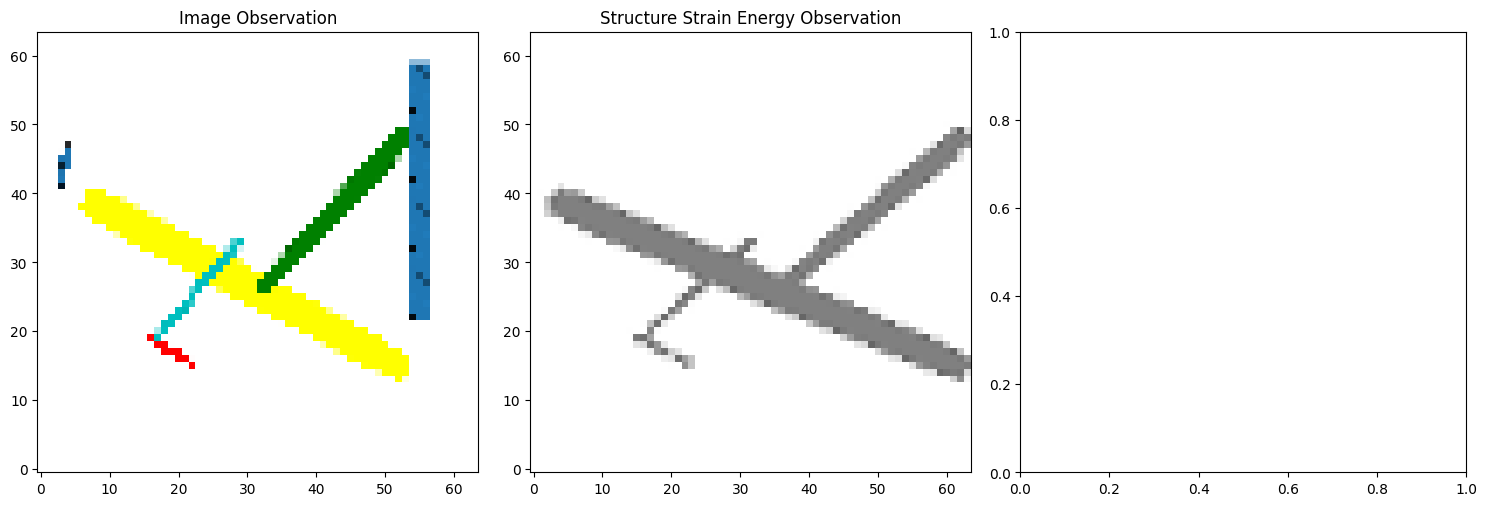

In [4]:
# Assuming you have the expert_dataset defined
expert_dataset = ExpertDataSet(expert_observations, expert_actions, train_env)
# Get a random sample from the dataset
sample_idx = np.random.randint(len(expert_dataset))
sample = expert_dataset[sample_idx]

# Extract the observation and reward from the sample
observation, action = sample

# Subplot with image, strain_energy, and structure_strain_energy observations:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot image observation
axes[0].imshow(observation['image'].T, cmap='gray', origin='lower')
axes[0].axis('on')
axes[0].set_title("Image Observation")

# Plot strain_energy observation
axes[1].imshow(observation['structure_strain_energy'].T, origin='lower')
axes[1].axis('on')
axes[1].set_title("Structure Strain Energy Observation")

print(action)
plt.tight_layout()
plt.show()

In [5]:
chosen_policy = "MlpPolicy" if observation_type == 'box_dense' else "MultiInputPolicy"

feature_extractor = ImageDictExtractor if observation_type == 'image' else CustomBoxDense

# Load the YAML file
env=train_env

with open("algorithms.yaml", "r") as file:
    config = yaml.safe_load(file)

# Extract the parameters for the desired algorithm
algorithm_name = "SAC"  # or "TD3"
algorithm_params = config[algorithm_name]

policy_kwargs = dict(
    features_extractor_class=feature_extractor,
    net_arch = config['common']['net_arch'],
    share_features_extractor = False
)

# Create the model based on the algorithm name and parameters
if algorithm_name == "SAC":
    model = SAC(env=env,
                policy = chosen_policy, 
                policy_kwargs=policy_kwargs,
                device=device, 
                **algorithm_params)

elif algorithm_name == "PPO":
    model = PPO(env=env, 
                policy = chosen_policy, 
                policy_kwargs=policy_kwargs,
                device = device, 
                **algorithm_params)

elif algorithm_name == "TD3":
    # Create the action noise object
    n_actions = env.action_space.shape[-1]
    action_noise_params = algorithm_params.pop("action_noise")
    action_noise = NormalActionNoise(mean=action_noise_params["mean"] * np.ones(n_actions),
                                     sigma=action_noise_params["sigma"] * np.ones(n_actions))
    model = TD3(env=env,
                policy =chosen_policy, 
                policy_kwargs=policy_kwargs,
                action_noise=action_noise,
                device=device, 
                **algorithm_params)

# Get the current date and time
current_datetime = datetime.now().strftime("%Y%m%d_%H%M%S")

# Create the tb_log_name string
tb_log_name = f"{algorithm_name}_{current_datetime}"

In [6]:
from torchinfo import summary
total_params = sum(p.numel() for p in model.policy.parameters())
print(f"Total number of parameters: {total_params:,}")
data = {k: v for k, v in observation.items()}
# Assuming you have a PyTorch model named 'model' and the input size is (3, 224, 224)
summary(model.policy)


Total number of parameters: 46,682,128


Layer (type:depth-idx)                   Param #
MultiInputPolicy                         --
├─Actor: 1-1                             --
│    └─ImageDictExtractor: 2-1           --
│    │    └─ReLU: 3-1                    --
│    │    └─ModuleDict: 3-2              259,584
│    └─Sequential: 2-2                   --
│    │    └─Linear: 3-3                  8,651,264
│    │    └─ReLU: 3-4                    --
│    │    └─Linear: 3-5                  262,656
│    │    └─ReLU: 3-6                    --
│    │    └─Linear: 3-7                  262,656
│    │    └─ReLU: 3-8                    --
│    └─Linear: 2-3                       3,078
│    └─Linear: 2-4                       3,078
├─ContinuousCritic: 1-2                  --
│    └─ImageDictExtractor: 2-5           --
│    │    └─ReLU: 3-9                    --
│    │    └─ModuleDict: 3-10             259,584
│    └─Sequential: 2-6                   --
│    │    └─Linear: 3-11                 8,654,336
│    │    └─ReLU: 3-12         

In [7]:
model.policy

MultiInputPolicy(
  (actor): Actor(
    (features_extractor): ImageDictExtractor(
      (activ_func): ReLU()
      (extractors): ModuleDict(
        (design_variables): Sequential(
          (0): Linear(in_features=48, out_features=128, bias=True)
          (1): ReLU()
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=128, out_features=128, bias=True)
          (4): ReLU()
          (5): Dropout(p=0.0, inplace=False)
          (6): Flatten(start_dim=1, end_dim=-1)
        )
        (image): Sequential(
          (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (1): ReLU()
          (2): Dropout(p=0.0, inplace=False)
          (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (4): ReLU()
          (5): Dropout(p=0.0, inplace=False)
          (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (7): ReLU()
          (8): Dropout(p=0.0, inplace=False)
          (9): Flat

In [8]:
pretrain_agent(
    model,
    expert_observations,
    expert_actions,
    env,
    test_env = eval_env,
    batch_size=4096*2,
    epochs=500,
    scheduler_gamma=0.98,
    learning_rate=1.0,
    log_interval=5,
    no_cuda=False,
    seed=1,
    verbose=True,
    test_batch_size=512,
    early_stopping_patience=300,
    plot_curves=True,
    tensorboard_log_dir="tb_logs/imitation",
    save_path="checkpoints/imitation_SAC",
    comet_ml_api_key="No20MKxPKu7vWLOUQCFBRO8mo",
    comet_ml_project_name="pretraining_rl",
    comet_ml_experiment_name="PPO_1",
    eval_freq = 5,
    l2_reg_strength=0.0000,
)

2024-04-10 22:08:34.266278: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-10 22:08:34.804929: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvrtc.so.11.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/thomas/anaconda3/envs/SB3_update/lib/python3.10/site-packages/cv2/../../lib64:/local/cuda-11.3/lib64:/local/TensorRT-7.2.2.3/lib
2024-04-10 22:08:34.805069: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvrtc.so.11.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: 

tensor([[-0.2841,  0.9899, -0.1119, -0.7013,  0.3223, -0.2827],
        [-0.8840,  0.9819,  0.0050, -0.9922, -0.3120,  0.5928],
        [-0.8718, -0.1034, -0.7038, -0.9148, -0.4082,  0.0115],
        ...,
        [-0.8470, -0.7072,  0.7407,  0.8048,  0.3844,  0.9086],
        [-0.7270, -0.3864,  0.1392,  0.9583,  0.8978, -0.6340],
        [-0.5593, -0.8058,  0.5764,  0.4645,  0.7364,  0.6416]],
       device='cuda:0', dtype=torch.float64, grad_fn=<ToCopyBackward0>)
Train Epoch: 1 [8192/129926 (6%)]	Loss: 0.914917	Grad Norm: 0.358479	LR: 1.000000
tensor([[-0.5702, -0.5460, -0.4955, -0.8894,  0.4846, -0.4969],
        [-0.7087, -0.7169,  0.0612, -0.4439,  0.4411,  0.8313],
        [ 0.8690,  0.0462, -0.8302,  0.7618, -0.4699,  0.9225],
        ...,
        [ 0.3807, -0.5742, -0.4176,  0.9167, -0.3151,  0.8240],
        [-0.7811, -0.8588, -0.5761,  0.7133,  0.5141, -0.8474],
        [-0.3348,  0.9179,  0.5920, -0.3693,  0.5433, -0.9543]],
       device='cuda:0', dtype=torch.float64, grad_

Exception ignored in: <function _releaseLock at 0x7fd50af0f490>
Traceback (most recent call last):
  File "/home/thomas/anaconda3/envs/SB3_update/lib/python3.10/logging/__init__.py", line 228, in _releaseLock
    def _releaseLock():
KeyboardInterrupt: 


tensor([[-0.4298, -0.0354,  0.4389, -0.0788,  0.4361,  0.4184],
        [-0.3526, -0.0398,  0.3184, -0.1384,  0.4266,  0.6854],
        [-0.2530, -0.0849,  0.3919, -0.0329,  0.5076,  0.4491],
        ...,
        [-0.4872, -0.0748,  0.2188,  0.0158,  0.6190,  0.2025],
        [-0.3279, -0.0331,  0.2094,  0.0010,  0.4178,  0.6123],
        [-0.1799, -0.0579,  0.2009, -0.1384,  0.5377,  0.4605]],
       device='cuda:0', dtype=torch.float64, grad_fn=<ToCopyBackward0>)
Train Epoch: 3 [8192/129926 (6%)]	Loss: 0.339540	Grad Norm: 0.424051	LR: 0.960400
tensor([[-6.9404e-01, -8.8439e-02,  6.3611e-01, -7.8812e-02,  7.6198e-01,
          8.1670e-01],
        [-7.2082e-01,  9.8933e-03,  7.0060e-01,  4.0193e-04,  7.8266e-01,
          7.9262e-01],
        [-6.7460e-01,  2.7420e-02,  6.5084e-01, -9.0887e-03,  8.0100e-01,
          8.1774e-01],
        ...,
        [-6.8666e-01,  3.7013e-02,  6.6980e-01, -2.0641e-02,  7.8435e-01,
          8.1384e-01],
        [-7.0578e-01, -3.9583e-03,  6.4691e-01,

---
### Multiprocessing

In [11]:
#from transformers import AutoTokenizer, AutoModel
from stable_baselines3.common.vec_env import DummyVecEnv, VecCheckNan
import multiprocessing

#tokenizer = AutoTokenizer.from_pretrained("huggingface/CodeBERTa-small-v1")
#model = AutoModel.from_pretrained("huggingface/CodeBERTa-small-v1").to('cuda')

# Set number of cpus to use automatically:
num_cpu = multiprocessing.cpu_count()

print("Using {} cpus!".format(num_cpu))
observation_type = "image"

train_env = sogym(mode='train',observation_type=observation_type,vol_constraint_type = 'hard',resolution=50,check_connectivity=True)#,model=model,tokenizer=tokenizer)
env= make_vec_env(lambda:train_env, n_envs=num_cpu,vec_env_cls=SubprocVecEnv)
env = VecCheckNan(env, raise_exception=True)
#env=VecNormalize(env,gamma=1.0)

eval_env = sogym(mode='test',observation_type=observation_type,vol_constraint_type='hard',resolution=50,check_connectivity=True)#,model=model,tokenizer=tokenizer)
eval_env = make_vec_env(lambda:eval_env, n_envs=1,vec_env_cls=SubprocVecEnv)
#eval_env =VecNormalize(eval_env,gamma=1.0)


Using 64 cpus!


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

--- 
### Defining the model

In [12]:
from stable_baselines3.common.noise import NormalActionNoise, OrnsteinUhlenbeckActionNoise

# The noise objects for TD3
n_actions = env.action_space.shape[-1]
action_noise = NormalActionNoise(mean=np.zeros(n_actions), sigma=0.5 * np.ones(n_actions))

chosen_policy = "MlpPolicy" if observation_type == 'box_dense' else "MultiInputPolicy"

feature_extractor = ImageDictExtractor if observation_type == 'image' else CustomBoxDense

# Load the YAML file

with open("algorithms.yaml", "r") as file:
    config = yaml.safe_load(file)

# Extract the parameters for the desired algorithm
algorithm_name = "SAC"  # or "TD3"
algorithm_params = config[algorithm_name]

policy_kwargs = dict(
    features_extractor_class=feature_extractor,
    net_arch = config['common']['net_arch'],
    share_features_extractor = False,
)

# Create the model based on the algorithm name and parameters
if algorithm_name == "SAC":
    model = SAC(env=env,
                policy = chosen_policy, 
                policy_kwargs=policy_kwargs,
                #action_noise = action_noise,
                device=device, 
                **algorithm_params)

elif algorithm_name == "PPO":
    model = PPO(env=env, 
                policy = chosen_policy, 
                policy_kwargs=policy_kwargs,
                device = device, 
                **algorithm_params)

elif algorithm_name == "TD3":
    # Create the action noise object
    n_actions = env.action_space.shape[-1]
    action_noise_params = algorithm_params.pop("action_noise")
    action_noise = NormalActionNoise(mean=action_noise_params["mean"] * np.ones(n_actions),
                                     sigma=action_noise_params["sigma"] * np.ones(n_actions))
    model = TD3(env=env,
                policy =chosen_policy, 
                policy_kwargs=policy_kwargs,
                action_noise=action_noise,
                device=device, 
                **algorithm_params)

# Get the current date and time
current_datetime = datetime.now().strftime("%Y%m%d_%H%M%S")

# Create the tb_log_name string
tb_log_name = f"{algorithm_name}_{current_datetime}"

In [13]:
# Save a checkpoint every 1000 steps
checkpoint_callback = CheckpointCallback(
  save_freq=50000//num_cpu,
  save_path="./checkpoints/",
  name_prefix=tb_log_name,
  save_replay_buffer=True,
  save_vecnormalize=True,
)

eval_callback = EvalCallback(eval_env,
                             log_path='tb_logs',
                             eval_freq=5000//num_cpu,
                             deterministic=True,
                            n_eval_episodes=10,
                             render=False,
                             best_model_save_path='./checkpoints',
                             verbose=0)
import torch
from stable_baselines3.common.callbacks import BaseCallback

class GradientClippingCallback(BaseCallback):
    def __init__(self, clip_value: float, verbose: int = 0):
        super().__init__(verbose)
        self.clip_value = clip_value

    def _on_step(self) -> bool:
        if hasattr(self.model, "policy"):
            torch.nn.utils.clip_grad_norm_(self.model.policy.parameters(), self.clip_value)
        return True




callback_list = CallbackList([eval_callback,
                         checkpoint_callback,
                         MaxRewardCallback(verbose=1),
                         GradientClippingCallback(clip_value=10.0, verbose=1),
                         GradientNormCallback(verbose=1),
                         FigureRecorderCallback(check_freq=5000//num_cpu,eval_env=eval_env)
                         ])

--- 
### Training

Save the model:

If model is on-policy:
#model.save("sac_pendulum")
#loaded_model = SAC.load("sac_pendulum")

if model is off-policy, we also need to save the replay buffer:
#model.save_replay_buffer("sac_replay_buffer")
#loaded_model.load_replay_buffer("sac_replay_buffer")

If the environment is normalized:
#env.save('env_saved.pkl')
#env = VecNormalize.load('env_saved.pkl',env)


In [14]:
# Print all the model.policy parameters:

for name, param in model.policy.named_parameters():
    print(name, param.shape)

actor.features_extractor.extractors.design_variables.0.weight torch.Size([128, 48])
actor.features_extractor.extractors.design_variables.0.bias torch.Size([128])
actor.features_extractor.extractors.design_variables.3.weight torch.Size([128, 128])
actor.features_extractor.extractors.design_variables.3.bias torch.Size([128])
actor.features_extractor.extractors.image.0.weight torch.Size([32, 3, 3, 3])
actor.features_extractor.extractors.image.0.bias torch.Size([32])
actor.features_extractor.extractors.image.3.weight torch.Size([64, 32, 3, 3])
actor.features_extractor.extractors.image.3.bias torch.Size([64])
actor.features_extractor.extractors.image.6.weight torch.Size([128, 64, 3, 3])
actor.features_extractor.extractors.image.6.bias torch.Size([128])
actor.features_extractor.extractors.n_steps_left.0.weight torch.Size([128, 1])
actor.features_extractor.extractors.n_steps_left.0.bias torch.Size([128])
actor.features_extractor.extractors.n_steps_left.3.weight torch.Size([128, 128])
actor.fe

In [15]:
#model = SAC.load("checkpoints/imitation_SAC",env =env) #Saved model is with soft volume constraint and 75 r
model.set_parameters("checkpoints/imitation_SAC.zip")
#model.set_parameters("imitation_SAC_critic")

# #Freeze everything:
# for name, param in model.policy.named_parameters():
#     if param.requires_grad:
#         param.requires_grad=False

# # Unfreeze critic:
# for param in model.policy.critic.parameters():
#     if param.requires_grad==False:
#         param.requires_grad=True

# for param in model.policy.critic_target.parameters():
#     if param.requires_grad==False:
#         param.requires_grad=True
 
# #Reset critic networks:
# if hasattr(model.policy.critic_target, 'reset_parameters'):
#     print(' resetting')
#     model.policy.critic_target.reset_parameters()
    
# if hasattr(model.policy.critic, 'reset_parameters'):
#     print(' resetting')
#     model.policy.critic_target.reset_parameters() 

#print(model.batch_size)
#model.load_replay_buffer("sac_replay_buffer")
model.learn(20000000,
            callback=callback_list, 
            tb_log_name=tb_log_name
            )
#model.save('model_saved_march15',)
#model.save_replay_buffer("sac_replay_buffer_march15")

#env.save('env_saved.pkl')

/home/thomas/anaconda3/envs/SB3_update/lib/python3.10/site-packages/stable_baselines3/common/callbacks.py:414: UserWarning: Training and eval env are not of the same type<stable_baselines3.common.vec_env.vec_check_nan.VecCheckNan object at 0x7fc93411bc70> != <stable_baselines3.common.vec_env.subproc_vec_env.SubprocVecEnv object at 0x7fbb05e93010>
  warnings.warn("Training and eval env are not of the same type" f"{self.training_env} != {self.eval_env}")
/home/thomas/anaconda3/envs/SB3_update/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.reward to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.reward` for environment variables or `env.get_wrapper_attr('reward')` that will search the reminding wrappers.
  logger.warn(
/home/thomas/anaconda3/envs/SB3_update/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.reward to get variables from other wrappers is deprecat

KeyboardInterrupt: 

In [ ]:
model.save('imitation_SAC_critic')

---
### Let's visualize the agent's performance:

In [ ]:
env=sogym(mode='train',observation_type='image',vol_constraint_type='hard' ,resolution = 50)
#env= make_vec_env(lambda:env, n_envs=1,vec_env_cls=SubprocVecEnv)
env

[-0.45084208 -0.6196898   0.09775901  0.08562005 -0.6068028  -0.2731769 ]
[-0.39078236 -0.552323    0.06692231  0.00492871 -0.60554457 -0.31692517]
[-0.38510835 -0.15872407  0.07184839 -0.38176912 -0.5579868  -0.32513887]
[-0.34414232 -0.05186987  0.03793955 -0.3199352  -0.514287   -0.32949364]
[-0.3365829   0.2699256   0.04909801 -0.40723407 -0.39889908 -0.256208  ]
[-0.21261054  0.1356157   0.11291325 -0.26657045 -0.36370713 -0.2738819 ]
[-0.05037349  0.02053773  0.3253739  -0.32322854 -0.29293525 -0.2721809 ]
[-0.00223839  0.0816108   0.41234756 -0.17857927 -0.24306583 -0.32128817]
Desired volume: 0.31 Obtained volume: 0.061391948215072954
Env reward: 0.0


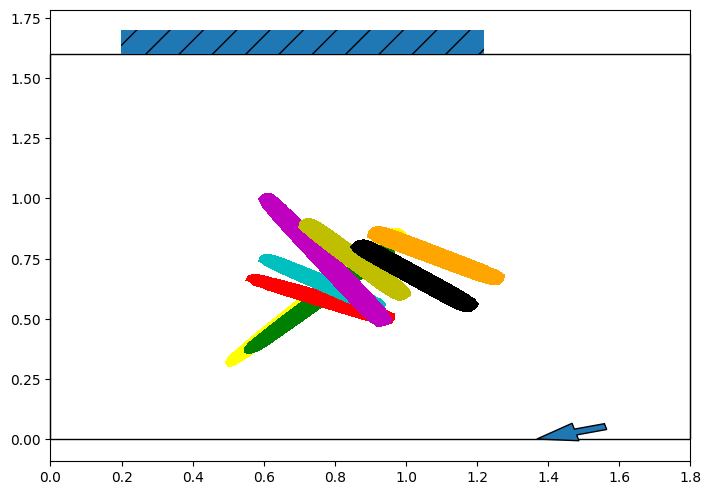

In [39]:
obs,info=env.reset()
dones=False
saved_conditions = env.conditions
saved_nelx, saved_nely = env.nelx, env.nely
saved_dx, saved_dy = env.dx, env.dy
#use deepcopy to save 
while dones== False:
    action, _states = model.predict(obs,deterministic=True)
    print(action)
    obs, rewards, dones,truncated, info = env.step(action)
print("Desired volume:",saved_conditions['volfrac'],"Obtained volume:",env.volume)
print("Env reward:",rewards)
env.plot()

In [ ]:
xval, f0val,it, H, Phimax, allPhi, den, N, cfg = run_mmc(saved_conditions,saved_nelx,saved_nely,saved_dx,saved_dy,plotting='contour')